# Compact Convolutional Transformers

As discussed in the <a href="https://arxiv.org/abs/2010.11929">Vision Transformers (ViT)</a> paper, a Transformer-based architecture for vision typically requires a larger dataset than usual, as well as a longer pre-training schedule. <a href="http://imagenet.org/">ImageNet-1k</a> (which has about a million images) is considered to fall under the medium-sized data regime with respect to ViTs. This is primarily because, unlike CNNs, ViTs (or a typical Transformer-based architecture) do not have well-informed inductive biases (such as convolutions for processing images). This begs the question: can't we combine the benefits of convolution and the benefits of Transformers in a single network architecture? These benefits include parameter-efficiency, and self-attention to process long-range and global dependencies (interactions between different regions in an image).

In <a href="https://arxiv.org/abs/2104.05704">Escaping the Big Data Paradigm with Compact Transformers</a>, Hassani et al. present an approach for doing exactly this. They proposed the <b>Compact Convolutional Transformer</b> (CCT) architecture. In this example, we will work on an implementation of CCT and we will see how well it performs on the CIFAR-10 dataset.

If you are unfamiliar with the concept of self-attention or Transformers, you can read <a href="https://livebook.manning.com/book/deep-learning-with-python-second-edition/chapter-11/r-3/312">this chapter</a> from François Chollet's book Deep Learning with Python. This example uses code snippets from another example, <a href="https://keras.io/examples/vision/image_classification_with_vision_transformer/">Image classification with Vision Transformer</a>.

<hr />

### Imports

In [1]:
from keras import layers
import keras

import matplotlib.pyplot as plt
import numpy as np

2025-04-20 03:23:44.172157: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745119424.187457   50568 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745119424.192204   50568 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1745119424.202916   50568 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1745119424.202931   50568 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1745119424.202933   50568 computation_placer.cc:177] computation placer alr

<hr />

### Hyperparameters and constants

In [2]:
positional_emb = True
conv_layers = 2
projection_dim = 128

num_heads = 2
transformer_units = [
    projection_dim,
    projection_dim,
]
transformer_layers = 2
stochastic_depth_rate = 0.1

learning_rate = 0.001
weight_decay = 0.0001
batch_size = 128
num_epochs = 30
image_size = 32

<hr />

### Load CIFAR-10 dataset

In [3]:
num_classes = 10
input_shape = (32, 32, 3)

(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

print(f"x_train shape: {x_train.shape} - y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape} - y_test shape: {y_test.shape}")

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 9s 0us/step
x_train shape: (50000, 32, 32, 3) - y_train shape: (50000, 10)
x_test shape: (10000, 32, 32, 3) - y_test shape: (10000, 10)


<hr />

### The CCT tokenizer

The first recipe introduced by the CCT authors is the tokenizer for processing the images. In a standard ViT, images are organized into uniform non-overlapping patches. This eliminates the boundary-level information present in between different patches. This is important for a neural network to effectively exploit the locality information. The figure below presents an illustration of how images are organized into patches.

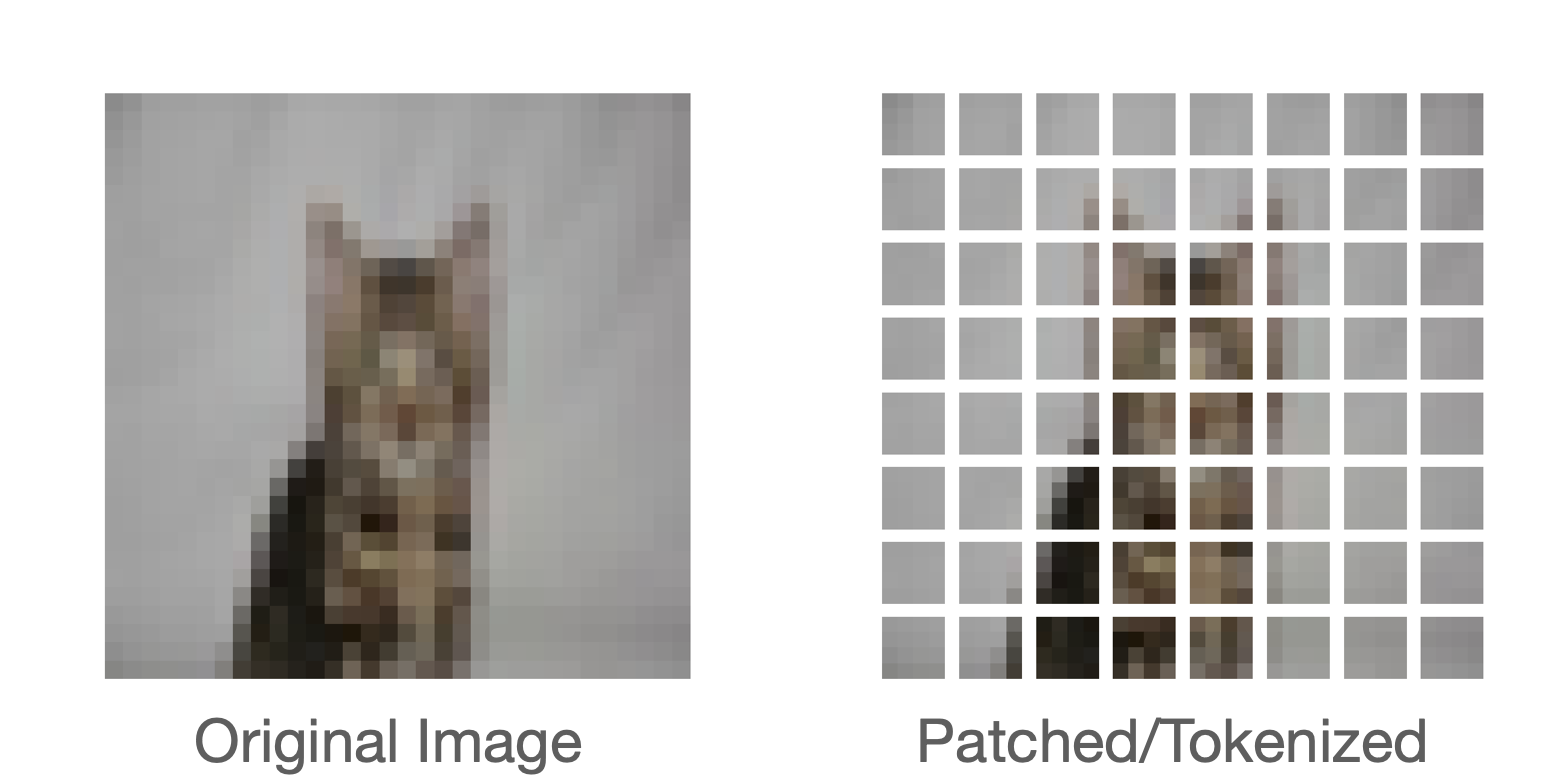class CCTTokenizer(layers.Layer):

We already know that convolutions are quite good at exploiting locality information. So, based on this, the authors introduce an all-convolution mini-network to produce image patches.

In [4]:
class CCTTokenizer(layers.Layer):
    def __init__(
        self,
        kernel_size=3,
        stride=1,
        padding=1,
        pooling_kernel_size=3,
        pooling_stride=2,
        num_conv_layers=conv_layers,
        num_output_channels=[64, 128],
        positional_emb=positional_emb,
        **kwargs,
    ):
        super().__init__(**kwargs)

        # This is our tokenizer.
        self.conv_model = keras.Sequential()
        for i in range(num_conv_layers):
            self.conv_model.add(
                layers.Conv2D(
                    num_output_channels[i],
                    kernel_size,
                    stride,
                    padding="valid",
                    use_bias=False,
                    activation="relu",
                    kernel_initializer="he_normal",
                )
            )
            self.conv_model.add(layers.ZeroPadding2D(padding))
            self.conv_model.add(
                layers.MaxPooling2D(pooling_kernel_size, pooling_stride, "same")
            )

        self.positional_emb = positional_emb

    def call(self, images):
        outputs = self.conv_model(images)
        # After passing the images through our mini-network the spatial dimensions
        # are flattened to form sequences.
        reshaped = keras.ops.reshape(
            outputs,
            (
                -1,
                keras.ops.shape(outputs)[1] * keras.ops.shape(outputs)[2],
                keras.ops.shape(outputs)[-1],
            ),
        )
        return reshaped


Positional embeddings are optional in CCT. If we want to use them, we can use the Layer defined below.

In [5]:
class PositionEmbedding(keras.layers.Layer):
    def __init__(
        self,
        sequence_length,
        initializer="glorot_uniform",
        **kwargs,
    ):
        super().__init__(**kwargs)
        if sequence_length is None:
            raise ValueError("`sequence_length` must be an Integer, received `None`.")
        self.sequence_length = int(sequence_length)
        self.initializer = keras.initializers.get(initializer)

    def get_config(self):
        config = super().get_config()
        config.update(
            {
                "sequence_length": self.sequence_length,
                "initializer": keras.initializers.serialize(self.initializer),
            }
        )
        return config

    def build(self, input_shape):
        feature_size = input_shape[-1]
        self.position_embeddings = self.add_weight(
            name="embeddings",
            shape=[self.sequence_length, feature_size],
            initializer=self.initializer,
            trainable=True,
        )

        super().build(input_shape)

    def call(self, inputs, start_index=0):
        shape = keras.ops.shape(inputs)
        feature_length = shape[-1]
        sequence_length = shape[-2]
        # trim to match the length of the input sequence, which might be less
        # than the sequence_length of the layer.
        position_embeddings = keras.ops.convert_to_tensor(self.position_embeddings)
        position_embeddings = keras.ops.slice(
            position_embeddings,
            (start_index, 0),
            (sequence_length, feature_length),
        )
        return keras.ops.broadcast_to(position_embeddings, shape)

    def compute_output_shape(self, input_shape):
        return input_shape

<hr />

### Sequence Pooling

Another recipe introduced in CCT is attention pooling or sequence pooling. In ViT, only the feature map corresponding to the class token is pooled and is then used for the subsequent classification task (or any other downstream task).

In [6]:
class SequencePooling(layers.Layer):
    def __init__(self):
        super().__init__()
        self.attention = layers.Dense(1)

    def call(self, x):
        attention_weights = keras.ops.softmax(self.attention(x), axis=1)
        attention_weights = keras.ops.transpose(attention_weights, axes=(0, 2, 1))
        weighted_representation = keras.ops.matmul(attention_weights, x)
        return keras.ops.squeeze(weighted_representation, -2)

<hr />

### Stochastic depth for regularization

<a href="https://arxiv.org/abs/1603.09382">Stochastic depth</a> is a regularization technique that randomly drops a set of layers. During inference, the layers are kept as they are. It is very much similar to <a href="https://jmlr.org/papers/v15/srivastava14a.html">Dropout</a> but only that it operates on a block of layers rather than individual nodes present inside a layer. In CCT, stochastic depth is used just before the residual blocks of a Transformers encoder.

In [7]:
# Referred from: github.com:rwightman/pytorch-image-models.
class StochasticDepth(layers.Layer):
    def __init__(self, drop_prop, **kwargs):
        super().__init__(**kwargs)
        self.drop_prob = drop_prop
        self.seed_generator = keras.random.SeedGenerator(1337)

    def call(self, x, training=None):
        if training:
            keep_prob = 1 - self.drop_prob
            shape = (keras.ops.shape(x)[0],) + (1,) * (len(x.shape) - 1)
            random_tensor = keep_prob + keras.random.uniform(
                shape, 0, 1, seed=self.seed_generator
            )
            random_tensor = keras.ops.floor(random_tensor)
            return (x / keep_prob) * random_tensor
        return x

<hr />

### MLP for the Transformers encoder

In [8]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=keras.ops.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

<hr />

### Data augmentation

In the <a href="https://arxiv.org/abs/2104.05704">original paper</a>, the authors use <a href="https://arxiv.org/abs/1805.09501">AutoAugment</a> to induce stronger regularization. For this example, we will be using the standard geometric augmentations like random cropping and flipping.

In [9]:
# Note the rescaling layer. These layers have pre-defined inference behavior.
data_augmentation = keras.Sequential(
    [
        layers.Rescaling(scale=1.0 / 255),
        layers.RandomCrop(image_size, image_size),
        layers.RandomFlip("horizontal"),
    ],
    name="data_augmentation",
)

2025-04-20 03:31:04.006111: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


<hr />

### The final CCT model

In CCT, outputs from the Transformers encoder are weighted and then passed on to the final task-specific layer (in this example, we do classification).

In [10]:
def create_cct_model(
    image_size=image_size,
    input_shape=input_shape,
    num_heads=num_heads,
    projection_dim=projection_dim,
    transformer_units=transformer_units,
):
    inputs = layers.Input(input_shape)

    # Augment data.
    augmented = data_augmentation(inputs)

    # Encode patches.
    cct_tokenizer = CCTTokenizer()
    encoded_patches = cct_tokenizer(augmented)

    # Apply positional embedding.
    if positional_emb:
        sequence_length = encoded_patches.shape[1]
        encoded_patches += PositionEmbedding(sequence_length=sequence_length)(
            encoded_patches
        )

    # Calculate Stochastic Depth probabilities.
    dpr = [x for x in np.linspace(0, stochastic_depth_rate, transformer_layers)]

    # Create multiple layers of the Transformer block.
    for i in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-5)(encoded_patches)

        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)

        # Skip connection 1.
        attention_output = StochasticDepth(dpr[i])(attention_output)
        x2 = layers.Add()([attention_output, encoded_patches])

        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-5)(x2)

        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)

        # Skip connection 2.
        x3 = StochasticDepth(dpr[i])(x3)
        encoded_patches = layers.Add()([x3, x2])

    # Apply sequence pooling.
    representation = layers.LayerNormalization(epsilon=1e-5)(encoded_patches)
    weighted_representation = SequencePooling()(representation)

    # Classify outputs.
    logits = layers.Dense(num_classes)(weighted_representation)
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)
    return model

<hr />

### Model training and evaluation

In [12]:
def run_experiment(model):
    optimizer = keras.optimizers.AdamW(learning_rate=0.001, weight_decay=0.0001)

    model.compile(
        optimizer=optimizer,
        loss=keras.losses.CategoricalCrossentropy(
            from_logits=True, label_smoothing=0.1
        ),
        metrics=[
            keras.metrics.CategoricalAccuracy(name="accuracy"),
            keras.metrics.TopKCategoricalAccuracy(5, name="top-5-accuracy"),
        ],
    )

    checkpoint_filepath = "/tmp/checkpoint.weights.h5"
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True,
    )

    history = model.fit(
        x=x_train,
        y=y_train,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_split=0.1,
        callbacks=[checkpoint_callback],
    )

    model.load_weights(checkpoint_filepath)
    _, accuracy, top_5_accuracy = model.evaluate(x_test, y_test)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

    return history


cct_model = create_cct_model()
history = run_experiment(cct_model)

Epoch 1/30
352/352 ━━━━━━━━━━━━━━━━━━━━ 172s 476ms/step - accuracy: 0.2526 - loss: 2.1206 - top-5-accuracy: 0.7452 - val_accuracy: 0.4826 - val_loss: 1.5974 - val_top-5-accuracy: 0.9280
Epoch 2/30
352/352 ━━━━━━━━━━━━━━━━━━━━ 167s 474ms/step - accuracy: 0.5061 - loss: 1.5601 - top-5-accuracy: 0.9302 - val_accuracy: 0.5822 - val_loss: 1.4135 - val_top-5-accuracy: 0.9574
Epoch 3/30
352/352 ━━━━━━━━━━━━━━━━━━━━ 167s 476ms/step - accuracy: 0.5880 - loss: 1.3994 - top-5-accuracy: 0.9531 - val_accuracy: 0.6250 - val_loss: 1.3293 - val_top-5-accuracy: 0.9644
Epoch 4/30
352/352 ━━━━━━━━━━━━━━━━━━━━ 167s 475ms/step - accuracy: 0.6305 - loss: 1.3096 - top-5-accuracy: 0.9638 - val_accuracy: 0.6586 - val_loss: 1.2428 - val_top-5-accuracy: 0.9734
Epoch 5/30
352/352 ━━━━━━━━━━━━━━━━━━━━ 167s 474ms/step - accuracy: 0.6683 - loss: 1.2279 - top-5-accuracy: 0.9700 - val_accuracy: 0.6724 - val_loss: 1.2358 - val_top-5-accuracy: 0.9696
Epoch 6/30
352/352 ━━━━━━━━━━━━━━━━━━━━ 167s 474ms/step - accuracy: 0.

Let's now visualize the training progress of the model.

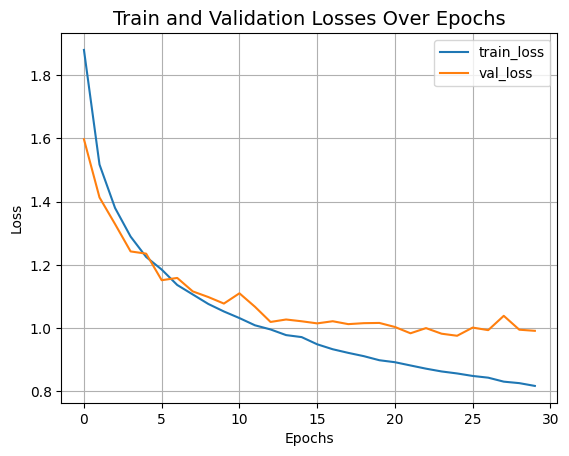

In [13]:
plt.plot(history.history["loss"], label="train_loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Train and Validation Losses Over Epochs", fontsize=14)
plt.legend()
plt.grid()
plt.show()

The CCT model we just trained has just <b>0.4 million</b> parameters, and it gets us to ~79% top-1 accuracy within 30 epochs. The plot above shows no signs of overfitting as well. This means we can train this network for longer (perhaps with a bit more regularization) and may obtain even better performance. This performance can further be improved by additional recipes like cosine decay learning rate schedule, other data augmentation techniques like <a href="https://arxiv.org/abs/1805.09501">AutoAugment</a>, <a href="https://arxiv.org/abs/1710.09412">MixUp</a> or <a href="https://arxiv.org/abs/1905.04899">Cutmix</a>. With these modifications, the authors present 95.1% top-1 accuracy on the CIFAR-10 dataset. The authors also present a number of experiments to study how the number of convolution blocks, Transformers layers, etc. affect the final performance of CCTs.

For a comparison, a ViT model takes about <b>4.7 million</b> parameters and <b>100</b> epochs of training to reach a top-1 accuracy of 78.22% on the CIFAR-10 dataset. You can refer to <a href="https://colab.research.google.com/gist/sayakpaul/1a80d9f582b044354a1a26c5cb3d69e5/image_classification_with_vision_transformer.ipynb">this notebook</a> to know about the experimental setup.

The authors also demonstrate the performance of Compact Convolutional Transformers on NLP tasks and they report competitive results there.